## 直近 n個のデータから10分後の終値を予測させる

In [1]:
# ドライブマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ライブラリのインポート
!pip install oandapyV20
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'IPAPGothic'
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
import oandapyV20.endpoints.instruments as instruments
import datetime
from statistics import mean
from statistics import median
import calendar
import datetime
from math import floor
import time
import threading
import json
import random
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.externals.joblib import dump, load
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
import feather

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
# OANDA API v20の口座IDとAPIトークン
accountID = "101-009-12789646-001"
access_token = "1ab53171ce4413f408de6da28ea23089-6426c3d3cc947dba212b3766d1be45c6"
# OANDAのデモ口座へのAPI接続
api = API(access_token=access_token, environment="practice")

### 怒濤の関数定義

In [0]:
# APIから取得したレートをPandasのDataFrameへ
def to_dataframe(r):
    data = []
    for raw in r.response['candles']:
        data.append([raw['time'], raw['volume'], raw['mid']['o'], raw['mid']['h'], raw['mid']['l'], raw['mid']['c']])

    # リストからPandas DataFrameへ変換
    df = pd.DataFrame(data)
    df.columns = ['Time', 'Volume', 'Open', 'High', 'Low', 'Close']
    df['Time'] = pd.to_datetime(df['Time'])
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col].apply(float)
    return df

In [0]:
def get_data(count, gran, year, month, day, hour, minute, second):
    # OANDA API v20の口座IDとAPIトークン
    accountID = "101-009-12789646-001"
    access_token = "1ab53171ce4413f408de6da28ea23089-6426c3d3cc947dba212b3766d1be45c6"
    # OANDAのデモ口座へのAPI接続
    api = API(access_token=access_token, environment="practice")
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    _from = datetime.datetime(year=year, month=month, day=day,
                              hour=hour, minute=minute, second=second).strftime(fmt)
    params = {
        "count": count,
        "granularity": gran,
        'from': _from,
#         'dailyAlignment': 0
    }
    r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
    api.request(r)
    df = to_dataframe(r)
    return df

In [0]:
def get_data_super(start, end, gran):
    # OANDA API v20の口座IDとAPIトークン
    accountID = "101-009-12789646-001"
    access_token = "1ab53171ce4413f408de6da28ea23089-6426c3d3cc947dba212b3766d1be45c6"
    # OANDAのデモ口座へのAPI接続
    api = API(access_token=access_token, environment="practice")
    # xxxx-xx-xx～xxxx-xx-xx の期間のデータを取得してデータフレームを返す
    s_year, s_month, s_day, s_hour, s_minute, s_second = map(int, start.split('-'))
    e_year, e_month, e_day, e_hour, e_minute, e_second = map(int, end.split('-'))
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    from_ = datetime.datetime(year=s_year, month=s_month, day=s_day,
                              hour=s_hour, minute=s_minute, second=s_second).strftime(fmt)
    to_ = datetime.datetime(year=e_year, month=e_month, day=e_day,
                            hour=e_hour, minute=e_minute, second=e_second).strftime(fmt)
    df = pd.DataFrame()
    # 5000個制限に引っかからなければこっちの処理
    try:
        params = {
            "granularity": gran,
            'from': from_,
            'to': to_
        }
        r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
        api.request(r)
        df = to_dataframe(r)
    # 引っかかればこっちの処理
    except:
        i = True
        while i:
            df_tmp = get_data(count=5000, gran=gran, year=s_year, month=s_month, day=s_day,
                             hour=s_hour, minute=s_minute, second=s_second)
            df = pd.concat([df, df_tmp], ignore_index=True)
            index = df_tmp.tail(1).index[0]
            s_year = df_tmp.iat[index, 0].year
            s_month = df_tmp.iat[index, 0].month
            s_day = df_tmp.iat[index, 0].day
            s_hour = df_tmp.iat[index, 0].hour
            s_minute = (df_tmp.iat[index, 0].minute + 1) % 60
            s_second = df_tmp.iat[index, 0].second
#             print('{}-{}-{}-{}-{}-{}'.format(s_year, s_month, s_day, s_hour, s_minute, s_second))
            # 5000個ずつ取得してエンド超えたら止める
            if s_year == e_year:
                i = False
        # 止めたらはみ出した分をここで切り落とす
        for i in range(len(df.index) - 5000, len(df.index)):
            if df.iat[i, 0].year == e_year and df.iat[i, 0].month == e_month and df.iat[i, 0].day == e_day:
                df = df[0:i]
                break
    # ボリンジャーバンドを追加
    sigma = 1
    df['BB20,+{}'.format(sigma)] = df['BB20,-{}'.format(sigma)] = 0
    df['BB20,+{}'.format(sigma)] = df['BB20,+{}'.format(sigma)].apply(float)
    df['BB20,-{}'.format(sigma)] = df['BB20,-{}'.format(sigma)].apply(float)
    for i in range(20, len(df)):
        df.iat[i, 6] = round(mean(df['Close'][i-20:i]) + (np.std(df['Close'][i-20:i]) * sigma), 3)
        df.iat[i, 7] = round(mean(df['Close'][i-20:i]) - (np.std(df['Close'][i-20:i]) * sigma), 3)
    # シグナル追加
    df['Lシグナル'] = df['Sシグナル'] = 0
    for i in range(len(df)):
        if df.iat[i, 6] < df.iat[i, 5]:
            df.iat[i, 8] = 1
        if df.iat[i, 7] > df.iat[i, 5]:
            df.iat[i, 9] = 1
    # 移動平均追加
    df['SMA20'] = 0
    df['SMA20'] = df['SMA20'].apply(float)
    for i in range(20, len(df)):
        df.iat[i, 10] = round(mean(df['Close'][i-20:i]), 3)
    # BB と SMA で参照した最初の分を落とす
    df = df[20:]
    df.reset_index(drop=True, inplace=True)
    return df

In [0]:
def get_evaluation(pos_df):
    # 勝率
    win_c = pos_df[pos_df['pips'] >=0].shape[0]
    WP = round(win_c / len(pos_df.index) * 100, 2)
    print('勝率: {}%'.format(WP))
    # ペイオフレシオ
    win_p = mean(pos_df[pos_df['pips'] >=0]['pips'])
    los_p = mean(pos_df[pos_df['pips'] < 0]['pips']) * (-1)
    RR = round(win_p / los_p, 4)
    print('ペイオフレシオ: {}'.format(RR))
    # 期待値
    win_pro = mean(pos_df[pos_df['pips'] >=0]['profit'])
    los_pro = mean(pos_df[pos_df['pips'] < 0]['profit']) * (-1)
    E = round(P * win_pro - pos_df[pos_df['pips'] < 0].shape[0] / len(pos_df.index) * los_pro, 2)
    print('期待値: {}円'.format(E))
    DD = round(pos_df.sort_values(by='profit', ascending=True).iat[0, 5], 2)
    print('最大ドローダウン: -{}円'.format(DD))
    return WP, RR, E, DD

In [0]:
def set_profit(tmp_i, i, pos, entry_rate, exit_rate, assets, df, pos_df, pos_count, lot):
    fee = 0.008
    pos_count+=1
    if pos == 'entry_long':
        pips = (exit_rate - entry_rate - fee) * 100
        l_s = 'long'
    else:
        pips = (entry_rate - exit_rate - fee) * 100
        l_s = 'short'
    profit = lot * 25 * pips / 100
    assets = round(assets + profit, 4)
    tmp_se = pd.Series( [lot, 'long', df.iat[tmp_i,0], entry_rate, df.iat[i+1,0],
                        exit_rate, pips, profit, assets ], index=pos_df.columns )
    pos_df = pos_df.append( tmp_se, ignore_index=True )
    pos = 'None'
    return assets, pos_df, pos_count, pos

In [0]:
# 訓練データ作る関数
def get_dataset(df):
    LGB_df = pd.DataFrame()
    
    # 実行
    for i in range(10, len(df.index)-10):
        LGB_df_tmp = pd.DataFrame(columns=['10Close'])
        y = df.iat[i+10, 5] # こやつが正解ラベル
        tmp_se = pd.Series( [y], index=LGB_df_tmp.columns )
        LGB_df_tmp = LGB_df_tmp.append( tmp_se, ignore_index=True )
        # 直近10個を横にずらーっと追加
        for j in range(i-10, i):
            tmp_df = df[j:j+1]
            tmp_df.reset_index(drop=True, inplace=True)
            LGB_df_tmp = pd.concat([LGB_df_tmp, tmp_df], axis=1)
        # 縦に結合
        LGB_df = pd.concat([LGB_df, LGB_df_tmp], axis=0)

    return LGB_df

In [0]:
# 訓練データ作る関数 -改-
def get_dataset_kai(df):
    LGB_df = pd.DataFrame()
    # for文10回回すのは最初だけ
    LGB_df_tmp = pd.DataFrame(columns=['10Close'])
    y = df.iat[20, 5] # こやつが正解ラベル
    tmp_se = pd.Series( [y], index=LGB_df_tmp.columns )
    LGB_df_tmp = LGB_df_tmp.append( tmp_se, ignore_index=True )
    # 直近10個を横にずらーっと追加
    for j in range(10):
        tmp_df = df[j:j+1]
        tmp_df.reset_index(drop=True, inplace=True)
        LGB_df_tmp = pd.concat([LGB_df_tmp, tmp_df], axis=1)
    LGB_df_tmp.drop(['Time'], axis=1, inplace=True)
    # 縦に結合
    LGB_df = pd.concat([LGB_df, LGB_df_tmp], axis=0)
    
    # 実行
    for i in range(11, len(df.index)-10):
        tmp_se = pd.Series( [df.iat[i+10, 5]] ) # こやつが正解ラベル
        shift_se = LGB_df.iloc[i-11, 11:] # 一個上の行からずらす分
        latest_se = df[i:i+1].iloc[0, 1:] # 最新のTime以外
        LGB_se_tmp = pd.concat([tmp_se, shift_se, latest_se])
        LGB_se_tmp.name=i
        LGB_se_tmp.index=LGB_df.columns
        LGB_df = LGB_df.append(LGB_se_tmp)

    LGB_df.reset_index(drop=True, inplace=True)
    return LGB_df

In [0]:
# 訓練データ作る関数 -x3-
def get_dataset_x3(df, n):
    LGB_df = pd.DataFrame()
    for i in range(1, n+1):
        diff_tmp = df.iloc[:, [2,3,4,5,6,7,10]].diff(i)*100
        diff_tmp['Volume'] = df.iloc[:, [1]].shift(i)
        diff_tmp['Lシグナル'] = df.iloc[:, [8]].shift(i)
        diff_tmp['Sシグナル'] = df.iloc[:, [9]].shift(i)
        LGB_df = pd.concat([LGB_df, diff_tmp], axis=1)
    LGB_df['y'] = df['Close'].diff(-10)*100
    LGB_df = LGB_df[n:(len(LGB_df)-n)]
    LGB_df.reset_index(drop=True, inplace=True)
    return LGB_df

In [0]:
# 訓練データ作る関数 (multiclass用)
def get_dataset_mc(df, n, m):
    LGB_df = pd.DataFrame()
    for i in range(1, n+1):
        diff_tmp = df.iloc[:, [2,3,4,5,6,7,10]].diff(i)*100
        diff_tmp['Volume'] = df.iloc[:, [1]].shift(i)
        diff_tmp['Lシグナル'] = df.iloc[:, [8]].shift(i)
        diff_tmp['Sシグナル'] = df.iloc[:, [9]].shift(i)
        LGB_df = pd.concat([LGB_df, diff_tmp], axis=1)
    LGB_df['y'] = df['Close'].diff(-10)*100
    LGB_df = LGB_df[n:(len(LGB_df)-n)]
    LGB_df_1 = LGB_df[LGB_df['y'] >= m].assign(target=1)
    LGB_df_2 = LGB_df[LGB_df['y'] <= -m].assign(target=2)
    LGB_df_3 = LGB_df.query('-{} < y < {}'.format(m, m)).assign(target=0)
    LGB_df_c = pd.concat([LGB_df_1, LGB_df_2, LGB_df_3], axis=0)
    LGB_df_c.drop(['y'], axis=1, inplace=True)
    LGB_df_c.reset_index(drop=True, inplace=True)
    return LGB_df_c

In [0]:
# 訓練データ作る関数 (binary用)
def get_dataset_bc(df, n, m):
    LGB_df = pd.DataFrame()
    for i in range(1, n+1):
        diff_tmp = df.iloc[:, [2,3,4,5,6,7,10]].diff(i)*100
        diff_tmp['Volume'] = df.iloc[:, [1]].shift(i)
        diff_tmp['Lシグナル'] = df.iloc[:, [8]].shift(i)
        diff_tmp['Sシグナル'] = df.iloc[:, [9]].shift(i)
        LGB_df = pd.concat([LGB_df, diff_tmp], axis=1)
    LGB_df['y'] = df['Close'].diff(-10)*100
    LGB_df = LGB_df[n:(len(LGB_df)-n)]
    LGB_df_1 = LGB_df[LGB_df['y'] >= m].assign(target=1)
    LGB_df_2 = LGB_df.query('y < {}'.format(m)).assign(target=0)
    LGB_df_c = pd.concat([LGB_df_1, LGB_df_2], axis=0)
    # LGB_df_c.drop(['y'], axis=1, inplace=True)
    # LGB_df_c = LGB_df_c.sample(frac=1, random_state=1729)
    LGB_df_c.reset_index(drop=True, inplace=True)
    return LGB_df_c

In [0]:
LGB_df = get_dataset_x3(df, 50)
LGB_df

### データ読み込み

In [0]:
# df = pd.read_csv('/content/drive/My Drive/machine_learning/trading/oanda/data/df.csv')
df = pd.read_csv('/content/drive/My Drive/machine_learning/trading/oanda/data/df_sma.csv')
# LGB_df = pd.read_csv('/content/drive/My Drive/machine_learning/trading/oanda/data/LGB_df_BB.csv')
# LGB_df = pd.read_csv('/content/drive/My Drive/machine_learning/trading/oanda/data/LGB_df_SMA.csv')
# df_10 = pd.read_csv('/content/drive/My Drive/machine_learning/trading/oanda/data/df_10.csv')
df_5 = pd.read_csv('/content/drive/My Drive/machine_learning/trading/oanda/data/df_5.csv')
df_2017 = pd.read_csv('/content/drive/My Drive/machine_learning/trading/oanda/data/df_2017.csv')

In [0]:
df.head()

,Time,Volume,Open,High,Low,Close,"BB20,+1","BB20,-1",Lシグナル,Sシグナル
0,2018-01-01 22:21:00+00:00,2,112.641,112.641,112.636,112.636,112.673,112.641,0,1
1,2018-01-01 22:22:00+00:00,4,112.642,112.646,112.638,112.646,112.672,112.639,0,0
2,2018-01-01 22:23:00+00:00,9,112.650,112.650,112.633,112.642,112.670,112.638,0,0
3,2018-01-01 22:24:00+00:00,21,112.646,112.646,112.632,112.644,112.668,112.637,0,0
4,2018-01-01 22:25:00+00:00,14,112.639,112.656,112.634,112.634,112.667,112.636,0,1


In [0]:
LGB_df.head()

,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,...,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,y
10,-0.004,-0.001,-0.011,-0.008,0.000,-0.002,-0.001,13.0,0.0,1.0,-0.017,-0.023,-0.037,-0.015,-0.001,-0.004,-0.002,6.0,0.0,1.0,-0.022,-0.034,-0.017,-0.025,-0.001,-0.005,-0.003,43.0,0.0,0.0,-0.014,-0.038,-0.040,-0.021,-0.002,-0.007,-0.004,82.0,0.0,1.0,...,-0.028,-0.043,-0.033,-0.004,-0.010,-0.006,21.0,0.0,0.0,-0.035,-0.032,-0.044,-0.031,-0.006,-0.011,-0.008,9.0,0.0,0.0,-0.027,-0.028,-0.049,-0.035,-0.008,-0.012,-0.010,4.0,0.0,0.0,-0.026,-0.023,-0.047,-0.025,-0.009,-0.014,-0.011,2.0,0.0,1.0,0.006
11,-0.009,-0.012,0.015,-0.007,0.000,-0.003,-0.002,15.0,0.0,1.0,-0.013,-0.013,0.004,-0.015,0.000,-0.005,-0.003,13.0,0.0,1.0,-0.026,-0.035,-0.022,-0.022,-0.001,-0.007,-0.004,6.0,0.0,1.0,-0.031,-0.046,-0.002,-0.032,-0.001,-0.008,-0.005,43.0,0.0,0.0,...,-0.050,-0.030,-0.030,-0.003,-0.012,-0.008,14.0,0.0,1.0,-0.040,-0.040,-0.028,-0.040,-0.004,-0.013,-0.008,21.0,0.0,0.0,-0.044,-0.044,-0.029,-0.038,-0.006,-0.014,-0.010,9.0,0.0,0.0,-0.036,-0.040,-0.034,-0.042,-0.008,-0.015,-0.012,4.0,0.0,0.0,-0.004
12,0.002,0.010,-0.010,0.001,0.001,-0.003,-0.001,2.0,0.0,1.0,-0.007,-0.002,0.005,-0.006,0.001,-0.006,-0.003,15.0,0.0,1.0,-0.011,-0.003,-0.006,-0.014,0.001,-0.008,-0.004,13.0,0.0,1.0,-0.024,-0.025,-0.032,-0.021,0.000,-0.010,-0.005,6.0,0.0,1.0,...,-0.035,-0.036,-0.029,-0.002,-0.014,-0.008,84.0,0.0,1.0,-0.031,-0.040,-0.040,-0.029,-0.002,-0.015,-0.009,14.0,0.0,1.0,-0.038,-0.030,-0.038,-0.039,-0.003,-0.016,-0.009,21.0,0.0,0.0,-0.042,-0.034,-0.039,-0.037,-0.005,-0.017,-0.011,9.0,0.0,0.0,0.000
13,-0.006,-0.014,0.008,-0.003,-0.001,-0.003,-0.002,23.0,0.0,1.0,-0.004,-0.004,-0.002,-0.002,0.000,-0.006,-0.003,2.0,0.0,1.0,-0.013,-0.016,0.013,-0.009,0.000,-0.009,-0.005,15.0,0.0,1.0,-0.017,-0.017,0.002,-0.017,0.000,-0.011,-0.006,13.0,0.0,1.0,...,-0.054,-0.027,-0.030,-0.002,-0.016,-0.009,82.0,0.0,1.0,-0.028,-0.049,-0.028,-0.032,-0.003,-0.017,-0.010,84.0,0.0,1.0,-0.037,-0.054,-0.032,-0.032,-0.003,-0.018,-0.011,14.0,0.0,1.0,-0.044,-0.044,-0.030,-0.042,-0.004,-0.019,-0.011,21.0,0.0,0.0,0.013
14,-0.002,0.000,-0.020,0.000,0.000,-0.003,-0.001,1.0,0.0,1.0,-0.008,-0.014,-0.012,-0.003,-0.001,-0.006,-0.003,23.0,0.0,1.0,-0.006,-0.004,-0.022,-0.002,0.000,-0.009,-0.004,2.0,0.0,1.0,-0.015,-0.016,-0.007,-0.009,0.000,-0.012,-0.006,15.0,0.0,1.0,...,-0.050,-0.024,-0.034,-0.001,-0.017,-0.009,43.0,0.0,0.0,-0.029,-0.054,-0.047,-0.030,-0.002,-0.019,-0.010,82.0,0.0,1.0,-0.030,-0.049,-0.048,-0.032,-0.003,-0.020,-0.011,84.0,0.0,1.0,-0.039,-0.054,-0.052,-0.032,-0.003,-0.021,-0.012,14.0,0.0,1.0,0.008


### LGB用のデータ作成

In [0]:
df = get_data_super(start='2018-01-01-00-00-00', end='2019-01-01-00-00-00', gran='M1')

findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.


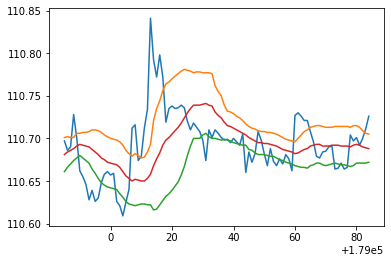

In [0]:
fig, ax = plt.subplots()
ax.plot(df['Close'][i:i+100])
ax.plot(df['BB20,+1'][i:i+100])
ax.plot(df['BB20,-1'][i:i+100])
ax.plot(df['SMA20'][i:i+100])
plt.show()

In [0]:
i = 179000-15
df[i:i+10]

,Time,Volume,Open,High,Low,Close,"BB20,+1","BB20,-1",Lシグナル,Sシグナル,SMA20
178985,2018-06-29 20:56:00+00:00,15,110.712,110.712,110.690,110.697,110.701,110.661,0,0,110.681
178986,2018-06-29 20:57:00+00:00,8,110.694,110.694,110.686,110.686,110.702,110.666,0,0,110.684
178987,2018-06-29 20:58:00+00:00,5,110.688,110.690,110.684,110.690,110.701,110.670,0,0,110.686
178988,2018-06-29 20:59:00+00:00,9,110.690,110.728,110.689,110.728,110.701,110.674,1,0,110.688
178989,2018-07-01 21:00:00+00:00,7,110.675,110.701,110.624,110.701,110.706,110.677,0,0,110.691
178990,2018-07-01 21:01:00+00:00,11,110.705,110.705,110.636,110.662,110.706,110.680,0,1,110.693
178991,2018-07-01 21:02:00+00:00,11,110.662,110.668,110.642,110.655,110.707,110.677,0,1,110.692
178992,2018-07-01 21:03:00+00:00,2,110.650,110.650,110.646,110.646,110.707,110.674,0,1,110.691
178993,2018-07-01 21:04:00+00:00,7,110.641,110.641,110.622,110.628,110.708,110.671,0,1,110.690
178994,2018-07-01 21:05:00+00:00,60,110.633,110.640,110.621,110.639,110.710,110.664,0,1,110.687


In [0]:
# 2018-07-01 ～ 2018-12-31
df_7_12 = df[178989:]

In [0]:
# LGB_df.to_csv('LGB_df_BB.csv', index=False)
df.to_csv('df_sma.csv', index=False)

In [0]:
LGB_df.to_csv('LGB_df_SMA.csv', index=False)

In [0]:
LGB_df = pd.read_csv('LGB_df_BB.csv')

In [0]:
LGB_df_s = LGB_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [0]:
LGB_df.loc[0, ['Close.9']]
# 110.658

Close.9    110.658
Name: 0, dtype: float64

### ここからML

In [0]:
# BBなしで学習させたモデルを読み込み
LGB_1 = load('LGB.cmp')

In [0]:
X = LGB_df.drop(['y'], axis=1)
y = LGB_df[['y']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# LightGBM が扱うデータセットの形式に直す
dtrain = lgb.Dataset(X_train, y_train)
dtest = lgb.Dataset(X_test, y_test, reference=dtrain)
params = {
    'objective': 'regression',
    'seed': 1729,
    'learning_rate': 0.1,
    'num_boosting_round': 5000
    }
LGB = lgb.train(params, dtrain)
y_pred = LGB.predict(X_test, num_iteration=LGB.best_iteration)
print(round(np.sqrt(mean_squared_error(y_test, y_pred)), 5))
# 3.94438

3.94438


In [0]:
j=160000
df_tmp = df[j:j+2000]
LGB_df_2 = get_dataset_x2(df_tmp)
X_2 = LGB_df_2.drop(['y'], axis=1)
y_2 = LGB_df_2[['y']].copy()
y_pred_2 = LGB.predict(X_2)
y_pred_2 = np.round(y_pred_2, decimals=3)
# バックテスト
fee = 0.008
y_2['pred'] = y_pred_2
y_2['Error'] = y_2['y'] - y_2['pred']
y_X_2 = pd.concat([y_2, X_2], axis=1)
check_df = y_X_2.iloc[:, range(2)]
win = lose = win_pips = lose_pips = 0
for i in range(len(check_df)):
    if check_df.iat[i, 1] > 0:
        pass
win_pips = round(win_pips, 3)
lose_pips = round(lose_pips, 3)
print('win: {}, lose: {}, win_pips: {}, lose_pips: {}'.format(win, lose, win_pips, lose_pips))

win: 0, lose: 0, win_pips: 0, lose_pips: 0


In [0]:
check_df

,y,pred
160010,-25.0,-0.586
160011,-26.0,-0.683
160012,-32.0,-0.683
160013,-27.0,-0.340
160014,-12.0,-0.268
...,...,...
161985,47.0,0.041
161986,44.0,-0.089
161987,46.0,-0.191
161988,48.0,-0.058


### 分類問題にしてみよう

In [15]:
LGB_df_bc = get_dataset_bc(df, 50, 10)
LGB_df_bc

,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,...,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,y,target
0,0.7,0.4,0.0,-0.7,-0.1,0.0,-0.1,11.0,0.0,0.0,1.9,1.1,0.9,0.0,-0.2,-0.1,-0.1,7.0,0.0,0.0,1.4,1.6,0.9,0.8,-0.4,-0.1,-0.3,6.0,0.0,0.0,1.4,1.6,1.0,0.8,-0.6,-0.2,-0.4,14.0,0.0,0.0,...,-2.0,-2.1,-2.3,-3.0,-2.7,11.0,0.0,0.0,0.0,-1.0,-1.0,-1.9,-2.3,-2.8,-2.6,11.0,0.0,0.0,-0.8,-0.6,-0.2,-0.7,-2.3,-2.9,-2.6,17.0,0.0,1.0,-1.8,-1.8,-2.0,-1.9,-2.3,-2.9,-2.6,8.0,0.0,0.0,10.7,1
1,-1.2,-1.1,-0.4,-0.3,-0.2,0.0,-0.1,15.0,0.0,0.0,-0.5,-0.7,-0.4,-1.0,-0.3,0.0,-0.2,11.0,0.0,0.0,0.7,0.0,0.5,-0.3,-0.4,-0.1,-0.2,7.0,0.0,0.0,0.2,0.5,0.5,0.5,-0.6,-0.1,-0.4,6.0,0.0,0.0,...,-2.6,-2.9,-2.5,-3.1,-2.8,6.0,0.0,0.0,-2.4,-2.7,-2.4,-2.4,-2.5,-3.0,-2.8,11.0,0.0,0.0,-1.2,-2.1,-1.4,-2.2,-2.5,-2.8,-2.7,11.0,0.0,0.0,-2.0,-1.7,-0.6,-1.0,-2.5,-2.9,-2.7,17.0,0.0,1.0,13.0,1
2,-0.2,-0.5,-1.2,-1.4,-0.1,0.0,0.0,11.0,0.0,0.0,-1.4,-1.6,-1.6,-1.7,-0.3,0.0,-0.1,15.0,0.0,0.0,-0.7,-1.2,-1.6,-2.4,-0.4,0.0,-0.2,11.0,0.0,0.0,0.5,-0.5,-0.7,-1.7,-0.5,-0.1,-0.2,7.0,0.0,0.0,...,-3.8,-4.8,-2.7,-3.2,-2.9,10.0,0.0,0.0,-2.8,-3.1,-3.8,-4.3,-2.6,-3.1,-2.8,6.0,0.0,0.0,-2.6,-3.2,-3.6,-3.8,-2.6,-3.0,-2.8,11.0,0.0,0.0,-1.4,-2.6,-2.6,-3.6,-2.6,-2.8,-2.7,11.0,0.0,0.0,12.4,1
3,-1.0,-0.4,0.0,0.4,-0.2,-0.1,-0.2,6.0,0.0,1.0,-1.2,-0.9,-1.2,-1.0,-0.3,-0.1,-0.2,11.0,0.0,0.0,-2.4,-2.0,-1.6,-1.3,-0.5,-0.1,-0.3,15.0,0.0,0.0,-1.7,-1.6,-1.6,-2.0,-0.6,-0.1,-0.4,11.0,0.0,0.0,...,-4.5,-4.6,-2.9,-3.5,-3.2,5.0,0.0,0.0,-3.9,-4.0,-3.8,-4.4,-2.9,-3.3,-3.1,10.0,0.0,0.0,-3.8,-3.5,-3.8,-3.9,-2.8,-3.2,-3.0,6.0,0.0,0.0,-3.6,-3.6,-3.6,-3.4,-2.8,-3.1,-3.0,11.0,0.0,0.0,15.4,1
4,0.0,-0.6,0.0,-0.4,-0.1,0.0,-0.1,14.0,0.0,0.0,-1.0,-1.0,0.0,0.0,-0.3,-0.1,-0.3,6.0,0.0,1.0,-1.2,-1.5,-1.2,-1.4,-0.4,-0.1,-0.3,11.0,0.0,0.0,-2.4,-2.6,-1.6,-1.7,-0.6,-0.1,-0.4,15.0,0.0,0.0,...,-4.0,-4.0,-3.1,-3.5,-3.4,8.0,0.0,0.0,-4.3,-5.0,-4.5,-5.0,-3.0,-3.5,-3.3,5.0,0.0,0.0,-3.9,-4.6,-3.8,-4.8,-3.0,-3.3,-3.2,10.0,0.0,0.0,-3.8,-4.1,-3.8,-4.3,-2.9,-3.2,-3.1,6.0,0.0,0.0,16.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356673,-0.7,0.1,2.4,0.5,0.0,0.0,0.0,37.0,1.0,0.0,0.0,-0.6,-0.3,-0.2,0.2,0.0,0.1,26.0,1.0,0.0,-0.1,0.8,-0.2,0.5,0.2,0.0,0.1,11.0,1.0,0.0,-0.1,0.9,-0.2,0.8,0.2,0.0,0.1,2.0,1.0,0.0,...,3.9,4.6,-1.5,1.7,0.1,6.0,0.0,1.0,3.3,4.3,3.6,4.6,-1.9,1.4,-0.3,3.0,0.0,1.0,2.9,3.9,3.2,4.2,-2.3,1.1,-0.6,4.0,0.0,1.0,3.0,3.5,2.7,3.2,-2.5,0.8,-0.8,6.0,0.0,1.0,0.2,0
356674,1.0,0.0,0.6,-0.4,0.1,0.0,0.0,26.0,1.0,0.0,0.3,0.1,3.0,0.1,0.1,0.0,0.0,37.0,1.0,0.0,1.0,-0.6,0.3,-0.6,0.3,0.0,0.1,26.0,1.0,0.0,0.9,0.8,0.4,0.1,0.3,0.0,0.1,11.0,1.0,0.0,...,4.0,2.4,-0.9,2.0,0.5,10.0,0.0,0.0,5.1,4.9,4.5,4.2,-1.4,1.7,0.1,6.0,0.0,1.0,4.3,4.3,4.2,4.2,-1.8,1.4,-0.3,3.0,0.0,1.0,3.9,3.9,3.8,3.8,-2.2,1.1,-0.6,4.0,0.0,1.0,0.4,0
356675,-0.5,-0.5,0.0,0.0,0.1,0.0,0.1,10.0,1.0,0.0,0.5,-0.5,0.6,-0.4,0.2,0.0,0.1,26.0,1.0,0.0,-0.2,-0.4,3.0,0.1,0.2,0.0,0.1,37.0,1.0,0.0,0.5,-1.1,0.3,-0.6,0.4,0.0,0.2,26.0,1.0,0.0,...,2.6,2.0,-0.2,2.0,0.9,12.0,0.0,0.0,4.2,2.6,4.0,2.4,-0.8,2.0,0.6,10.0,0.0,0.0,4.6,4.4,4.5,4.2,-1.3,1.7,0.2,6.0,0.0,1.0,3.8,3.8,4.2,4.2,-1.7,1.4,-0.2,3.0,0.0,1.0,0.8,0
356676,0.0,0.6,0.2,0.6,0.1,0.0,0.1,2.0,1.0,0.0,-0.5,0.1,0.2,0.6,0.2,0.0,0.2,10.0,1.0,0.0,0.5,0.1,0.8,0.2,0.3,0.0,0.2,26.0,1.0,0.0,-0.2,0.2,3.2,0.7,0.3,0.0,0.2,37.0,1.0,0.0,...,2.4,2.6,0.4,1.9,1.2,8.0,0.0,0.0,2.8,2.8,2.8,2.6,-0.1

In [17]:
df.shape

(356778, 11)

In [0]:
LGB_df_bc = pd.DataFrame()

In [0]:
df_5_1 = df_5[:700000]
df_5_2 = df_5[700000:1400000]
df_5_3 = df_5[1400000:]
LGB_df_bc_tmp = get_dataset_bc(df_5_3, 50, 10)
LGB_df_bc = pd.concat([LGB_df_bc, LGB_df_bc_tmp], axis=0)
LGB_df_bc.reset_index(drop=True, inplace=True)
LGB_df_bc

In [0]:
# feather
LGB_df_bc.columns = map(str, range(502))
# feather.write_dataframe(LGB_df_bc, 'LGB_df_bc_5.feather')
# tmp_df = feather.read_dataframe('LGB_df_bc_5.feather')
# LGB_df_bc = tmp_df

In [27]:
X_resampled.shape

(95300, 500)

In [28]:
y_resampled.shape

(95300, 1)

In [19]:
LGB_df_bc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501
0,0.7,0.4,0.0,-0.7,-0.1,0.0,-0.1,11.0,0.0,0.0,1.9,1.1,0.9,0.0,-0.2,-0.1,-0.1,7.0,0.0,0.0,1.4,1.6,0.9,0.8,-0.4,-0.1,-0.3,6.0,0.0,0.0,1.4,1.6,1.0,0.8,-0.6,-0.2,-0.4,14.0,0.0,0.0,...,-2.0,-2.1,-2.3,-3.0,-2.7,11.0,0.0,0.0,0.0,-1.0,-1.0,-1.9,-2.3,-2.8,-2.6,11.0,0.0,0.0,-0.8,-0.6,-0.2,-0.7,-2.3,-2.9,-2.6,17.0,0.0,1.0,-1.8,-1.8,-2.0,-1.9,-2.3,-2.9,-2.6,8.0,0.0,0.0,10.7,1
1,-1.2,-1.1,-0.4,-0.3,-0.2,0.0,-0.1,15.0,0.0,0.0,-0.5,-0.7,-0.4,-1.0,-0.3,0.0,-0.2,11.0,0.0,0.0,0.7,0.0,0.5,-0.3,-0.4,-0.1,-0.2,7.0,0.0,0.0,0.2,0.5,0.5,0.5,-0.6,-0.1,-0.4,6.0,0.0,0.0,...,-2.6,-2.9,-2.5,-3.1,-2.8,6.0,0.0,0.0,-2.4,-2.7,-2.4,-2.4,-2.5,-3.0,-2.8,11.0,0.0,0.0,-1.2,-2.1,-1.4,-2.2,-2.5,-2.8,-2.7,11.0,0.0,0.0,-2.0,-1.7,-0.6,-1.0,-2.5,-2.9,-2.7,17.0,0.0,1.0,13.0,1
2,-0.2,-0.5,-1.2,-1.4,-0.1,0.0,0.0,11.0,0.0,0.0,-1.4,-1.6,-1.6,-1.7,-0.3,0.0,-0.1,15.0,0.0,0.0,-0.7,-1.2,-1.6,-2.4,-0.4,0.0,-0.2,11.0,0.0,0.0,0.5,-0.5,-0.7,-1.7,-0.5,-0.1,-0.2,7.0,0.0,0.0,...,-3.8,-4.8,-2.7,-3.2,-2.9,10.0,0.0,0.0,-2.8,-3.1,-3.8,-4.3,-2.6,-3.1,-2.8,6.0,0.0,0.0,-2.6,-3.2,-3.6,-3.8,-2.6,-3.0,-2.8,11.0,0.0,0.0,-1.4,-2.6,-2.6,-3.6,-2.6,-2.8,-2.7,11.0,0.0,0.0,12.4,1
3,-1.0,-0.4,0.0,0.4,-0.2,-0.1,-0.2,6.0,0.0,1.0,-1.2,-0.9,-1.2,-1.0,-0.3,-0.1,-0.2,11.0,0.0,0.0,-2.4,-2.0,-1.6,-1.3,-0.5,-0.1,-0.3,15.0,0.0,0.0,-1.7,-1.6,-1.6,-2.0,-0.6,-0.1,-0.4,11.0,0.0,0.0,...,-4.5,-4.6,-2.9,-3.5,-3.2,5.0,0.0,0.0,-3.9,-4.0,-3.8,-4.4,-2.9,-3.3,-3.1,10.0,0.0,0.0,-3.8,-3.5,-3.8,-3.9,-2.8,-3.2,-3.0,6.0,0.0,0.0,-3.6,-3.6,-3.6,-3.4,-2.8,-3.1,-3.0,11.0,0.0,0.0,15.4,1
4,0.0,-0.6,0.0,-0.4,-0.1,0.0,-0.1,14.0,0.0,0.0,-1.0,-1.0,0.0,0.0,-0.3,-0.1,-0.3,6.0,0.0,1.0,-1.2,-1.5,-1.2,-1.4,-0.4,-0.1,-0.3,11.0,0.0,0.0,-2.4,-2.6,-1.6,-1.7,-0.6,-0.1,-0.4,15.0,0.0,0.0,...,-4.0,-4.0,-3.1,-3.5,-3.4,8.0,0.0,0.0,-4.3,-5.0,-4.5,-5.0,-3.0,-3.5,-3.3,5.0,0.0,0.0,-3.9,-4.6,-3.8,-4.8,-3.0,-3.3,-3.2,10.0,0.0,0.0,-3.8,-4.1,-3.8,-4.3,-2.9,-3.2,-3.1,6.0,0.0,0.0,16.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356673,-0.7,0.1,2.4,0.5,0.0,0.0,0.0,37.0,1.0,0.0,0.0,-0.6,-0.3,-0.2,0.2,0.0,0.1,26.0,1.0,0.0,-0.1,0.8,-0.2,0.5,0.2,0.0,0.1,11.0,1.0,0.0,-0.1,0.9,-0.2,0.8,0.2,0.0,0.1,2.0,1.0,0.0,...,3.9,4.6,-1.5,1.7,0.1,6.0,0.0,1.0,3.3,4.3,3.6,4.6,-1.9,1.4,-0.3,3.0,0.0,1.0,2.9,3.9,3.2,4.2,-2.3,1.1,-0.6,4.0,0.0,1.0,3.0,3.5,2.7,3.2,-2.5,0.8,-0.8,6.0,0.0,1.0,0.2,0
356674,1.0,0.0,0.6,-0.4,0.1,0.0,0.0,26.0,1.0,0.0,0.3,0.1,3.0,0.1,0.1,0.0,0.0,37.0,1.0,0.0,1.0,-0.6,0.3,-0.6,0.3,0.0,0.1,26.0,1.0,0.0,0.9,0.8,0.4,0.1,0.3,0.0,0.1,11.0,1.0,0.0,...,4.0,2.4,-0.9,2.0,0.5,10.0,0.0,0.0,5.1,4.9,4.5,4.2,-1.4,1.7,0.1,6.0,0.0,1.0,4.3,4.3,4.2,4.2,-1.8,1.4,-0.3,3.0,0.0,1.0,3.9,3.9,3.8,3.8,-2.2,1.1,-0.6,4.0,0.0,1.0,0.4,0
356675,-0.5,-0.5,0.0,0.0,0.1,0.0,0.1,10.0,1.0,0.0,0.5,-0.5,0.6,-0.4,0.2,0.0,0.1,26.0,1.0,0.0,-0.2,-0.4,3.0,0.1,0.2,0.0,0.1,37.0,1.0,0.0,0.5,-1.1,0.3,-0.6,0.4,0.0,0.2,26.0,1.0,0.0,...,2.6,2.0,-0.2,2.0,0.9,12.0,0.0,0.0,4.2,2.6,4.0,2.4,-0.8,2.0,0.6,10.0,0.0,0.0,4.6,4.4,4.5,4.2,-1.3,1.7,0.2,6.0,0.0,1.0,3.8,3.8,4.2,4.2,-1.7,1.4,-0.2,3.0,0.0,1.0,0.8,0
356676,0.0,0.6,0.2,0.6,0.1,0.0,0.1,2.0,1.0,0.0,-0.5,0.1,0.2,0.6,0.2,0.0,0.2,10.0,1.0,0.0,0.5,0.1,0.8,0.2,0.3,0.0,0.2,26.0,1.0,0.0,-0.2,0.2,3.2,0.7,0.3,0.0,0.2,37.0,1.0,0.0,...,2.4,2.6,0.4,1.9,1.2,8.0,0.0,0.0,2.8,2.8,2.8,2.6,-0.1,2.0,1.0,12.0,0.0,0.0,4.2,3.2,4.2,3.0,-0.7,2.0,0.7,10.0,0.0,0.0,4.6,5.0,4.7,4.8,-1.2,1.7,0.3,6.0,0.0,1.0,1.8,0


In [20]:
# nonシャッフル
X = LGB_df_bc.drop(['500', '501'], axis=1)
y = LGB_df_bc[['501']]
sampler = RandomUnderSampler(random_state=1729)
X_resampled, y_resampled = sampler.fit_resample(X, y)
y_resampled_f = y_resampled.flatten()
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_f, test_size=0.30, random_state=42)
# LightGBM が扱うデータセットの形式に直す
lgb_train = lgb.Dataset(X_train, y_train)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'seed': 1729,
    'learning_rate': 0.05,
    'num_boosting_round': 2000
    }
LGB = lgb.train(params, lgb_train)
for i in range(2, 9):
    y_pred = LGB.predict(X_test, num_iteration=LGB.best_iteration)
    K = round(i * 0.1, 1)
    print('K: {}'.format(K))
    for i in range(len(y_pred)):
        if y_pred[i] > K:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    acu = round(metrics.accuracy_score(y_test, y_pred), 5)
    pre = round(metrics.precision_score(y_test, y_pred), 5)
    rec = round(metrics.recall_score(y_test, y_pred), 5)
    f1 = round(metrics.f1_score(y_test, y_pred), 5)
    print('accuracy: {}, precision: {}, recall: {}, f1: {}'.format(acu, pre, rec, f1))
    conf = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf.ravel()
    print('tp: {}, tn: {}, fp: {}, fn: {}'.format(tp, tn, fp, fn))

K: 0.2
accuracy: 0.59552, precision: 0.54839, recall: 0.95958, f1: 0.69792
tp: 1377, tn: 378, fp: 1134, fn: 58
K: 0.3
accuracy: 0.68171, precision: 0.62034, recall: 0.89268, f1: 0.732
tp: 1281, tn: 728, fp: 784, fn: 154
K: 0.4
accuracy: 0.71802, precision: 0.67681, recall: 0.80557, f1: 0.7356
tp: 1156, tn: 960, fp: 552, fn: 279
K: 0.5
accuracy: 0.73091, precision: 0.72766, recall: 0.71498, f1: 0.72127
tp: 1026, tn: 1128, fp: 384, fn: 409
K: 0.6
accuracy: 0.72141, precision: 0.77265, recall: 0.60627, f1: 0.67942
tp: 870, tn: 1256, fp: 256, fn: 565
K: 0.7
accuracy: 0.68884, precision: 0.80833, recall: 0.47317, f1: 0.59692
tp: 679, tn: 1351, fp: 161, fn: 756
K: 0.8
accuracy: 0.62945, precision: 0.85072, recall: 0.2899, f1: 0.43243
tp: 416, tn: 1439, fp: 73, fn: 1019


In [0]:
# シャッフルver
X = LGB_df_bc.drop(['y', 'target'], axis=1)
y = LGB_df_bc[['target']]
sampler = RandomUnderSampler(random_state=1729)
X_resampled, y_resampled = sampler.fit_resample(X, y)
y_resampled_f = y_resampled.flatten()
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_f, test_size=0.30, random_state=42)
# LightGBM が扱うデータセットの形式に直す
lgb_train = lgb.Dataset(X_train, y_train)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'seed': 1729,
    'learning_rate': 0.05,
    'num_boosting_round': 2000
    }
LGB = lgb.train(params, lgb_train)
for i in range(2, 9):
    y_pred = LGB.predict(X_test, num_iteration=LGB.best_iteration)
    K = round(i * 0.1, 1)
    print('K: {}'.format(K))
    for i in range(len(y_pred)):
        if y_pred[i] > K:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    acu = round(metrics.accuracy_score(y_test, y_pred), 5)
    pre = round(metrics.precision_score(y_test, y_pred), 5)
    rec = round(metrics.recall_score(y_test, y_pred), 5)
    f1 = round(metrics.f1_score(y_test, y_pred), 5)
    print('accuracy: {}, precision: {}, recall: {}, f1: {}'.format(acu, pre, rec, f1))
    conf = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf.ravel()
    print('tp: {}, tn: {}, fp: {}, fn: {}'.format(tp, tn, fp, fn))

K: 0.2
accuracy: 0.59552, precision: 0.54785, recall: 0.96934, f1: 0.70005
tp: 1391, tn: 364, fp: 1148, fn: 44
K: 0.3
accuracy: 0.68442, precision: 0.62157, recall: 0.89965, f1: 0.73519
tp: 1291, tn: 726, fp: 786, fn: 144
K: 0.4
accuracy: 0.70614, precision: 0.66904, recall: 0.78467, f1: 0.72226
tp: 1126, tn: 955, fp: 557, fn: 309
K: 0.5
accuracy: 0.72548, precision: 0.72681, recall: 0.69895, f1: 0.71261
tp: 1003, tn: 1135, fp: 377, fn: 432
K: 0.6
accuracy: 0.71904, precision: 0.77318, recall: 0.59861, f1: 0.67478
tp: 859, tn: 1260, fp: 252, fn: 576
K: 0.7
accuracy: 0.69121, precision: 0.81896, recall: 0.46969, f1: 0.59699
tp: 674, tn: 1363, fp: 149, fn: 761
K: 0.8
accuracy: 0.63319, precision: 0.87821, recall: 0.28641, f1: 0.43195
tp: 411, tn: 1455, fp: 57, fn: 1024


In [0]:
X_resampled.shape

(9822, 500)

In [0]:
# ちゃんと予測してんのか???????
y_pred = LGB.predict(X_test, num_iteration=LGB.best_iteration)
arr = np.random.rand(len(y_pred))
K = 0.5
print('K: {}'.format(K))
for i in range(len(arr)):
    if arr[i] > K:
        arr[i] = 1
    else:
        arr[i] = 0
acu = round(metrics.accuracy_score(y_test, arr), 5)
pre = round(metrics.precision_score(y_test, arr), 5)
rec = round(metrics.recall_score(y_test, arr), 5)
f1 = round(metrics.f1_score(y_test, arr), 5)
print('accuracy: {}, precision: {}, recall: {}, f1: {}'.format(acu, pre, rec, f1))
conf = metrics.confusion_matrix(y_test, arr)
tn, fp, fn, tp = conf.ravel()
print('tp: {}, tn: {}, fp: {}, fn: {}'.format(tp, tn, fp, fn))

K: 0.5
accuracy: 0.48626, precision: 0.47318, recall: 0.48571, f1: 0.47937
tp: 697, tn: 736, fp: 776, fn: 738


In [0]:
# 生データ
# accuracy: 0.9860565960151022, recall: 0.007417397167902899
# tn: 105501, fp: 20, fn: 1472, tp: 11
# ダウンサンプリングで均衡データに
# accuracy: 0.7309127926705123, recall: 0.7149825783972126
# tn: 1128, fp: 384, fn: 409, tp: 1026
# K=0.4
# accuracy: 0.7180183237190363, recall: 0.805574912891986
# tn: 960, fp: 552, fn: 279, tp: 1156
# K=0.3
# accuracy: 0.6817102137767221, recall: 0.8926829268292683
# tn: 728, fp: 784, fn: 154, tp: 1281
# K=0.5 評価指標追加
# accuracy: 0.73091, precision: 0.72766, recall: 0.71498, f1: 0.72127
# tn: 1128, fp: 384, fn: 409, tp: 1026
# K=0.4
# accuracy: 0.71802, precision: 0.67681, recall: 0.80557, f1: 0.7356
# tn: 960, fp: 552, fn: 279, tp: 1156
# K=0.3
# accuracy: 0.68171, precision: 0.62034, recall: 0.89268, f1: 0.732
# tn: 728, fp: 784, fn: 154, tp: 1281
# K=0.2
# accuracy: 0.59552, precision: 0.54839, recall: 0.95958, f1: 0.69792
# tn: 378, fp: 1134, fn: 58, tp: 1377

In [0]:
(tn / (tn + fn) + tp / (tp + fp)) / 2

0.7307783884051551

### テストオオオオオオオオオオオオオ

In [0]:
df_2017 = get_data_super(start='2017-01-01-00-00-00', end='2018-01-01-00-00-00', gran='M1')

In [26]:
LGB_df_bc_tmp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,pred
0,0.2,0.2,-0.2,0.2,0.0,0.1,0.0,19.0,0.0,0.0,-3.4,-3.2,-1.7,-0.1,0.0,0.1,0.0,19.0,0.0,0.0,-2.6,-3.2,-3.8,-3.2,0.3,0.2,0.2,8.0,1.0,0.0,-2.2,-2.0,-3.6,-2.0,0.4,0.2,0.3,1.0,0.0,0.0,...,2.4,-7.2,-3.4,-5.4,55.0,0.0,1.0,0.8,-0.2,1.2,0.6,-7.1,-4.0,-5.6,65.0,0.0,1.0,-1.4,-4.6,-0.4,1.0,-6.9,-4.9,-6.0,83.0,0.0,1.0,-4.2,-8.4,-2.6,-1.2,-6.9,-5.6,-6.3,142.0,0.0,1.0,10.5,1,1.0
1,-0.1,0.0,-0.2,-0.1,-0.1,-0.1,0.0,10.0,0.0,0.0,0.1,0.2,0.2,-0.3,-0.1,-0.1,0.0,11.0,0.0,0.0,-0.1,0.2,0.4,-0.1,-0.1,-0.1,0.0,22.0,0.0,0.0,-2.1,-1.3,-0.4,-0.3,-0.3,-0.1,-0.1,24.0,0.0,0.0,...,5.9,8.7,13.1,10.9,52.0,1.0,0.0,5.4,3.8,5.1,4.1,9.5,13.2,11.4,36.0,1.0,0.0,6.1,6.4,6.2,5.5,10.1,13.4,11.8,26.0,1.0,0.0,4.2,4.9,5.6,5.5,10.8,13.8,12.3,32.0,1.0,0.0,10.3,1,1.0
2,-0.1,-1.0,-0.5,-0.6,-0.1,0.0,-0.1,18.0,0.0,0.0,-0.2,-1.0,-0.7,-0.7,-0.2,-0.1,-0.1,10.0,0.0,0.0,0.0,-0.8,-0.3,-0.9,-0.2,-0.1,-0.1,11.0,0.0,0.0,-0.2,-0.8,-0.1,-0.7,-0.2,-0.1,-0.1,22.0,0.0,0.0,...,3.9,8.1,12.8,10.5,65.0,1.0,0.0,4.2,4.2,5.9,5.3,8.6,13.1,10.8,52.0,1.0,0.0,5.3,2.8,4.6,3.5,9.4,13.2,11.3,36.0,1.0,0.0,6.0,5.4,5.7,4.9,10.0,13.4,11.7,26.0,1.0,0.0,11.2,1,1.0
3,0.0,-0.1,1.4,0.7,-0.2,-0.2,-0.2,39.0,0.0,0.0,0.8,0.7,1.5,0.1,-0.4,-0.3,-0.4,54.0,0.0,0.0,-2.0,-1.7,0.5,0.8,-0.7,-0.5,-0.6,43.0,0.0,1.0,-4.5,-3.4,-1.8,-1.7,-1.0,-0.5,-0.8,50.0,0.0,0.0,...,-3.2,2.3,0.7,1.5,29.0,1.0,0.0,-0.2,0.4,-0.3,-0.4,2.2,0.7,1.5,6.0,0.0,0.0,0.0,0.9,1.3,0.1,2.1,0.7,1.4,17.0,0.0,0.0,-1.1,-1.2,-0.5,0.1,1.5,0.9,1.2,26.0,0.0,0.0,11.9,1,1.0
4,-0.1,-1.1,-1.6,-1.1,0.0,0.0,0.0,26.0,0.0,0.0,-0.1,-1.2,-0.2,-0.4,-0.2,-0.2,-0.2,39.0,0.0,0.0,0.7,-0.4,-0.1,-1.0,-0.4,-0.3,-0.4,54.0,0.0,0.0,-2.1,-2.8,-1.1,-0.3,-0.7,-0.5,-0.6,43.0,0.0,1.0,...,-1.4,1.9,0.9,1.4,27.0,0.0,0.0,-1.3,-3.5,-2.1,-4.3,2.3,0.7,1.5,29.0,1.0,0.0,-0.3,-0.7,-1.9,-1.5,2.2,0.7,1.5,6.0,0.0,0.0,-0.1,-0.2,-0.3,-1.0,2.1,0.7,1.4,17.0,0.0,0.0,11.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363735,1.6,1.4,0.6,0.6,0.1,-0.1,0.0,6.0,1.0,0.0,2.4,2.7,1.4,2.2,0.1,-0.1,0.0,8.0,0.0,0.0,4.2,3.9,3.2,3.1,0.0,-0.2,-0.1,9.0,0.0,1.0,3.4,4.6,3.4,4.8,0.1,-0.6,-0.2,13.0,0.0,1.0,...,3.2,0.4,2.2,1.3,20.0,0.0,0.0,4.4,3.2,3.6,2.4,0.4,2.2,1.3,21.0,0.0,0.0,5.0,5.4,4.0,5.1,0.4,2.1,1.3,6.0,0.0,0.0,5.0,6.2,4.4,5.6,0.3,1.9,1.1,4.0,0.0,1.0,1.0,0,1.0
363736,0.2,0.3,1.0,0.8,0.2,0.0,0.1,27.0,1.0,0.0,1.8,1.7,1.6,1.4,0.3,-0.1,0.1,6.0,1.0,0.0,2.6,3.0,2.4,3.0,0.3,-0.1,0.1,8.0,0.0,0.0,4.4,4.2,4.2,3.9,0.2,-0.2,0.0,9.0,0.0,1.0,...,3.4,0.6,2.2,1.4,13.0,0.0,0.0,2.0,3.3,3.6,4.0,0.6,2.2,1.4,20.0,0.0,0.0,4.6,3.5,4.6,3.2,0.6,2.2,1.4,21.0,0.0,0.0,5.2,5.7,5.0,5.9,0.6,2.1,1.4,6.0,0.0,0.0,1.4,0,1.0
363737,1.4,0.5,0.0,-1.2,0.3,-0.1,0.1,23.0,1.0,0.0,1.6,0.8,1.0,-0.4,0.5,-0.1,0.2,27.0,1.0,0.0,3.2,2.2,1.6,0.2,0.6,-0.2,0.2,6.0,1.0,0.0,4.0,3.5,2.4,1.8,0.6,-0.2,0.2,8.0,0.0,0.0,...,2.7,0.9,2.1,1.5,2.0,0.0,0.0,4.6,4.2,3.2,2.2,0.9,2.1,1.5,13.0,0.0,0.0,3.4,3.8,3.6,2.8,0.9,2.1,1.5,20.0,0.0,0.0,6.0,4.0,4.6,2.0,0.9,2.1,1.5,21.0,0.0,0.0,0.0,0,1.0
363738,-1.8,-2.2,-1.4,-0.9,0.1,0.0,0.1,15.0,1.0,0.0,-0.4,-1.7,-1.4,-2.1,0.4,-0.1,0.2,23.0,1.0,0.0,-0.2,-1.4,-0.4,-1.3,0.6,-0.1,0.3,27.0,1.0,0.0,1.4,0.0,0.2,-0.7,0.7,-0.2,0.3,6.0,1.0,0.0,...,2.9,1.1,2.1,1.7,9.0,0.0,0.0,2.2,2.2,1.3,1.8,1.0,2.1,1.6,2.0,0.0,0.0,2.8,2.0,1.8,1.3,1.0,2.1,1.6,13.0,0.0,0.0,1.6,1.6,2.2,1.9,1.0,2.1,1.6,20.0,0.0,0.0,-0.7,0,1.0


In [27]:
y_pred_tmp

array([0.3925231 , 0.28377867, 0.3156234 , ..., 0.33958134, 0.27971128,
       0.24095668])

In [28]:
foot_gran_k = pd.DataFrame(columns=['K', 'accuracy', 'precision', 'recall', 'f1', 'tp', 'tn', 'fp', 'fn', 'profit'])

LGB_df_bc_tmp = get_dataset_bc(df_2017, 50, 10)
LGB_df_bc_tmp.columns = map(str, range(502))
X_tmp = LGB_df_bc_tmp.drop(['500', '501'], axis=1).to_numpy()
y_tmp = LGB_df_bc_tmp[['501']].to_numpy().flatten()
y_pred_tmp = LGB.predict(X_tmp, num_iteration=LGB.best_iteration)
LGB_df_bc_tmp = LGB_df_bc_tmp.assign((pred)=y_pred_tmp)

for i in range(2, 9+1):
    K = round(i * 0.1, 1)
    print(K)
    y_pred_tmp_tmp = LGB.predict(X_tmp, num_iteration=LGB.best_iteration)
    for i in range(len(y_pred_tmp)):
        if y_pred_tmp_tmp[i] > K:
            y_pred_tmp_tmp[i] = 1
        else:
            y_pred_tmp_tmp[i] = 0
    acu = round(metrics.accuracy_score(y_tmp, y_pred_tmp_tmp), 5)
    pre = round(metrics.precision_score(y_tmp, y_pred_tmp_tmp), 5)
    rec = round(metrics.recall_score(y_tmp, y_pred_tmp_tmp), 5)
    f1 = round(metrics.f1_score(y_tmp, y_pred_tmp_tmp), 5)
    print('accuracy: {}, precision: {}, recall: {}, f1: {}'.format(acu, pre, rec, f1))
    conf = metrics.confusion_matrix(y_tmp, y_pred_tmp_tmp)
    tn, fp, fn, tp = conf.ravel()
    print('tp: {}, tn: {}, fp: {}, fn: {}'.format(tp, tn, fp, fn))
    profit = LGB_df_bc_tmp[LGB_df_bc_tmp['pred'] > K]['500'].sum() - 0.008 * 100 * (tp + fp)
    tmp_se = pd.Series( [K, acu, pre, rec, f1, tp, tn, fp, fn, profit ], index=foot_gran_k.columns )
    foot_gran_k = foot_gran_k.append( tmp_se, ignore_index=True )

[0.3925231  0.28377867 0.3156234  ... 0.33958134 0.27971128 0.24095668]
0.2
accuracy: 0.13104, precision: 0.02872, recall: 0.98399, f1: 0.05581
tp: 9341, tn: 38322, fp: 315925, fn: 152
0.3
accuracy: 0.25045, precision: 0.03211, recall: 0.95112, f1: 0.06212
tp: 9029, tn: 82069, fp: 272178, fn: 464
0.4
accuracy: 0.35787, precision: 0.03572, recall: 0.90793, f1: 0.06873
tp: 8619, tn: 121553, fp: 232694, fn: 874
0.5
accuracy: 0.45683, precision: 0.03973, recall: 0.85505, f1: 0.07593
tp: 8117, tn: 158049, fp: 196198, fn: 1376
0.6
accuracy: 0.56023, precision: 0.04527, recall: 0.789, f1: 0.08563
tp: 7490, tn: 196288, fp: 157959, fn: 2003
0.7
accuracy: 0.67547, precision: 0.053, recall: 0.67787, f1: 0.09831
tp: 6435, tn: 239261, fp: 114986, fn: 3058
0.8
accuracy: 0.80412, precision: 0.06648, recall: 0.49879, f1: 0.11732
tp: 4735, tn: 287756, fp: 66491, fn: 4758
0.9
accuracy: 0.92725, precision: 0.09905, recall: 0.22079, f1: 0.13675
tp: 2096, tn: 335182, fp: 19065, fn: 7397


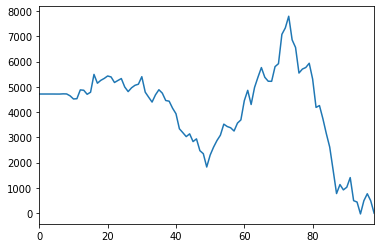

In [0]:
foot_gran_k['profit'].plot()

In [23]:
foot_gran_k[foot_gran_k['K']==0.4]

,K,accuracy,precision,recall,f1,tp,tn,fp,fn,profit
39,0.4,0.35787,0.03572,0.90793,0.06873,8619.0,121553.0,232694.0,874.0,-190227.6


In [22]:
foot_gran_k.sort_values(by='profit', ascending=False)

,K,accuracy,precision,recall,f1,tp,tn,fp,fn,profit
7,0.9,0.92725,0.09905,0.22079,0.13675,2096.0,335182.0,19065.0,7397.0,-16818.9
6,0.8,0.80412,0.06648,0.49879,0.11732,4735.0,287756.0,66491.0,4758.0,-50733.3
5,0.7,0.67547,0.05300,0.67787,0.09831,6435.0,239261.0,114986.0,3058.0,-91946.7
4,0.6,0.56023,0.04527,0.78900,0.08563,7490.0,196288.0,157959.0,2003.0,-127198.2
3,0.5,0.45683,0.03973,0.85505,0.07593,8117.0,158049.0,196198.0,1376.0,-160579.5
2,0.4,0.35787,0.03572,0.90793,0.06873,8619.0,121553.0,232694.0,874.0,-190227.6
1,0.3,0.25045,0.03211,0.95112,0.06212,9029.0,82069.0,272178.0,464.0,-221352.9
0,0.2,0.13104,0.02872,0.98399,0.05581,9341.0,38322.0,315925.0,152.0,-254269.8


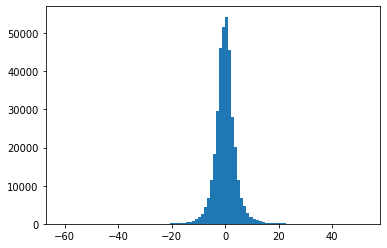

In [0]:
plt.hist(LGB_df_bc_tmp['y'], bins=100)
plt.show()

In [0]:
df_2017

,Time,Volume,Open,High,Low,Close,"BB20,+1","BB20,-1",Lシグナル,Sシグナル,SMA20
0,2017-01-02 23:20:00+00:00,92,117.356,117.382,117.350,117.367,117.369,117.284,0,0,117.326
1,2017-01-02 23:21:00+00:00,62,117.368,117.384,117.360,117.382,117.373,117.287,1,0,117.330
2,2017-01-02 23:22:00+00:00,130,117.380,117.380,117.331,117.348,117.375,117.299,0,0,117.337
3,2017-01-02 23:23:00+00:00,127,117.354,117.372,117.330,117.335,117.376,117.307,0,0,117.341
4,2017-01-02 23:24:00+00:00,121,117.335,117.344,117.320,117.344,117.376,117.312,0,0,117.344
...,...,...,...,...,...,...,...,...,...,...,...
363835,2017-12-29 21:55:00+00:00,3,112.680,112.684,112.680,112.684,112.684,112.672,0,0,112.678
363836,2017-12-29 21:56:00+00:00,1,112.680,112.680,112.680,112.680,112.684,112.672,0,0,112.678
363837,2017-12-29 21:57:00+00:00,3,112.684,112.684,112.679,112.684,112.684,112.673,0,0,112.679
363838,2017-12-29 21:58:00+00:00,1,112.689,112.689,112.689,112.689,112.685,112.674,1,0,112.679


### SMAなし
精度若干低下

In [0]:
LGB_df_bc = get_dataset_bc(df, 50, 10)
LGB_df_bc

,Open,High,Low,Close,"BB20,+1","BB20,-1",Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",Volume,Lシグナル,Sシグナル,Open,High,Low,Close,...,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",Volume,Lシグナル,Sシグナル,target
0,0.7,0.4,0.0,-0.7,-0.1,0.0,11.0,0.0,0.0,1.9,1.1,0.9,0.0,-0.2,-0.1,7.0,0.0,0.0,1.4,1.6,0.9,0.8,-0.4,-0.1,6.0,0.0,0.0,1.4,1.6,1.0,0.8,-0.6,-0.2,14.0,0.0,0.0,1.8,1.2,1.0,0.7,...,6.0,0.0,0.0,-1.2,-1.6,-2.0,-2.1,-2.3,-3.0,11.0,0.0,0.0,0.0,-1.0,-1.0,-1.9,-2.3,-2.8,11.0,0.0,0.0,-0.8,-0.6,-0.2,-0.7,-2.3,-2.9,17.0,0.0,1.0,-1.8,-1.8,-2.0,-1.9,-2.3,-2.9,8.0,0.0,0.0,1
1,-1.2,-1.1,-0.4,-0.3,-0.2,0.0,15.0,0.0,0.0,-0.5,-0.7,-0.4,-1.0,-0.3,0.0,11.0,0.0,0.0,0.7,0.0,0.5,-0.3,-0.4,-0.1,7.0,0.0,0.0,0.2,0.5,0.5,0.5,-0.6,-0.1,6.0,0.0,0.0,0.2,0.5,0.6,0.5,...,10.0,0.0,0.0,-2.6,-2.6,-2.6,-2.9,-2.5,-3.1,6.0,0.0,0.0,-2.4,-2.7,-2.4,-2.4,-2.5,-3.0,11.0,0.0,0.0,-1.2,-2.1,-1.4,-2.2,-2.5,-2.8,11.0,0.0,0.0,-2.0,-1.7,-0.6,-1.0,-2.5,-2.9,17.0,0.0,1.0,1
2,-0.2,-0.5,-1.2,-1.4,-0.1,0.0,11.0,0.0,0.0,-1.4,-1.6,-1.6,-1.7,-0.3,0.0,15.0,0.0,0.0,-0.7,-1.2,-1.6,-2.4,-0.4,0.0,11.0,0.0,0.0,0.5,-0.5,-0.7,-1.7,-0.5,-0.1,7.0,0.0,0.0,0.0,0.0,-0.7,-0.9,...,5.0,0.0,0.0,-2.9,-3.6,-3.8,-4.8,-2.7,-3.2,10.0,0.0,0.0,-2.8,-3.1,-3.8,-4.3,-2.6,-3.1,6.0,0.0,0.0,-2.6,-3.2,-3.6,-3.8,-2.6,-3.0,11.0,0.0,0.0,-1.4,-2.6,-2.6,-3.6,-2.6,-2.8,11.0,0.0,0.0,1
3,-1.0,-0.4,0.0,0.4,-0.2,-0.1,6.0,0.0,1.0,-1.2,-0.9,-1.2,-1.0,-0.3,-0.1,11.0,0.0,0.0,-2.4,-2.0,-1.6,-1.3,-0.5,-0.1,15.0,0.0,0.0,-1.7,-1.6,-1.6,-2.0,-0.6,-0.1,11.0,0.0,0.0,-0.5,-0.9,-0.7,-1.3,...,8.0,0.0,0.0,-4.3,-4.4,-4.5,-4.6,-2.9,-3.5,5.0,0.0,0.0,-3.9,-4.0,-3.8,-4.4,-2.9,-3.3,10.0,0.0,0.0,-3.8,-3.5,-3.8,-3.9,-2.8,-3.2,6.0,0.0,0.0,-3.6,-3.6,-3.6,-3.4,-2.8,-3.1,11.0,0.0,0.0,1
4,0.0,-0.6,0.0,-0.4,-0.1,0.0,14.0,0.0,0.0,-1.0,-1.0,0.0,0.0,-0.3,-0.1,6.0,0.0,1.0,-1.2,-1.5,-1.2,-1.4,-0.4,-0.1,11.0,0.0,0.0,-2.4,-2.6,-1.6,-1.7,-0.6,-0.1,15.0,0.0,0.0,-1.7,-2.2,-1.6,-2.4,...,4.0,0.0,0.0,-4.6,-4.8,-4.0,-4.0,-3.1,-3.5,8.0,0.0,0.0,-4.3,-5.0,-4.5,-5.0,-3.0,-3.5,5.0,0.0,0.0,-3.9,-4.6,-3.8,-4.8,-3.0,-3.3,10.0,0.0,0.0,-3.8,-4.1,-3.8,-4.3,-2.9,-3.2,6.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356673,-0.7,0.1,2.4,0.5,0.0,0.0,37.0,1.0,0.0,0.0,-0.6,-0.3,-0.2,0.2,0.0,26.0,1.0,0.0,-0.1,0.8,-0.2,0.5,0.2,0.0,11.0,1.0,0.0,-0.1,0.9,-0.2,0.8,0.2,0.0,2.0,1.0,0.0,1.1,1.1,1.0,0.8,...,10.0,0.0,0.0,4.1,4.9,3.9,4.6,-1.5,1.7,6.0,0.0,1.0,3.3,4.3,3.6,4.6,-1.9,1.4,3.0,0.0,1.0,2.9,3.9,3.2,4.2,-2.3,1.1,4.0,0.0,1.0,3.0,3.5,2.7,3.2,-2.5,0.8,6.0,0.0,1.0,0
356674,1.0,0.0,0.6,-0.4,0.1,0.0,26.0,1.0,0.0,0.3,0.1,3.0,0.1,0.1,0.0,37.0,1.0,0.0,1.0,-0.6,0.3,-0.6,0.3,0.0,26.0,1.0,0.0,0.9,0.8,0.4,0.1,0.3,0.0,11.0,1.0,0.0,0.9,0.9,0.4,0.4,...,12.0,0.0,0.0,4.7,3.1,4.0,2.4,-0.9,2.0,10.0,0.0,0.0,5.1,4.9,4.5,4.2,-1.4,1.7,6.0,0.0,1.0,4.3,4.3,4.2,4.2,-1.8,1.4,3.0,0.0,1.0,3.9,3.9,3.8,3.8,-2.2,1.1,4.0,0.0,1.0,0
356675,-0.5,-0.5,0.0,0.0,0.1,0.0,10.0,1.0,0.0,0.5,-0.5,0.6,-0.4,0.2,0.0,26.0,1.0,0.0,-0.2,-0.4,3.0,0.1,0.2,0.0,37.0,1.0,0.0,0.5,-1.1,0.3,-0.6,0.4,0.0,26.0,1.0,0.0,0.4,0.3,0.4,0.1,...,8.0,0.0,0.0,2.8,2.2,2.6,2.0,-0.2,2.0,12.0,0.0,0.0,4.2,2.6,4.0,2.4,-0.8,2.0,10.0,0.0,0.0,4.6,4.4,4.5,4.2,-1.3,1.7,6.0,0.0,1.0,3.8,3.8,4.2,4.2,-1.7,1.4,3.0,0.0,1.0,0
356676,0.0,0.6,0.2,0.6,0.1,0.0,2.0,1.0,0.0,-0.5,0.1,0.2,0.6,0.2,0.0,10.0,1.0,0.0,0.5,0.1,0.8,0.2,0.3,0.0,26.0,1.0,0.0,-0.2,0.2,3.2,0.7,0.3,0.0,37.0,1.0,0.0,0.5,-0.5,0.5,0.0,...,15.0,1.0,0.0,1.9,2.3,2.4,2.6,0.4,1.9,8.0,0.0,0.0,2.8,2.8,2.8,2.6,-0.1,2.0,12.0,

In [0]:
for i in range(2, 9):
    X = LGB_df_bc.drop(['target'], axis=1)
    y = LGB_df_bc[['target']]
    sampler = RandomUnderSampler(random_state=1729)
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    y_resampled_f = y_resampled.flatten()
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_f, test_size=0.30, random_state=42)
    # LightGBM が扱うデータセットの形式に直す
    lgb_train = lgb.Dataset(X_train, y_train)
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'seed': 1729,
        'learning_rate': 0.05,
        'num_boosting_round': 2000
        }
    LGB = lgb.train(params, lgb_train)
    y_pred = LGB.predict(X_test, num_iteration=LGB.best_iteration)
    # y_test_np = y_test.target.to_numpy()
    K = round(i * 0.1, 1)
    print('K: {}'.format(K))
    for i in range(len(y_pred)):
        if y_pred[i] > K:
            # print(y_pred[i])
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    acu = round(metrics.accuracy_score(y_test, y_pred), 5)
    pre = round(metrics.precision_score(y_test, y_pred), 5)
    rec = round(metrics.recall_score(y_test, y_pred), 5)
    f1 = round(metrics.f1_score(y_test, y_pred), 5)
    print('accuracy: {}, precision: {}, recall: {}, f1: {}'.format(acu, pre, rec, f1))
    conf = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf.ravel()
    print('tn: {}, fp: {}, fn: {}, tp: {}'.format(tn, fp, fn, tp))

K: 0.2
accuracy: 0.59281, precision: 0.54683, recall: 0.9561, f1: 0.69574
tn: 375, fp: 1137, fn: 63, tp: 1372
K: 0.3
accuracy: 0.67221, precision: 0.614, recall: 0.88014, f1: 0.72337
tn: 718, fp: 794, fn: 172, tp: 1263
K: 0.4
accuracy: 0.71632, precision: 0.67566, recall: 0.80279, f1: 0.73376
tn: 959, fp: 553, fn: 283, tp: 1152
K: 0.5
accuracy: 0.72616, precision: 0.7227, recall: 0.7101, f1: 0.71634
tn: 1121, fp: 391, fn: 416, tp: 1019
K: 0.6
accuracy: 0.71632, precision: 0.76958, recall: 0.59582, f1: 0.67164
tn: 1256, fp: 256, fn: 580, tp: 855
K: 0.7
accuracy: 0.68544, precision: 0.80976, recall: 0.46272, f1: 0.58891
tn: 1356, fp: 156, fn: 771, tp: 664
K: 0.8
accuracy: 0.62572, precision: 0.84874, recall: 0.28153, f1: 0.42282
tn: 1440, fp: 72, fn: 1031, tp: 404


### 学習データを1年分から10年分に
精度変わりなし

In [0]:
df_10 = get_data_super(start='2009-01-01-00-00-00', end='2019-01-01-00-00-00', gran='M1')

In [0]:
LGB_df_bc_10 = pd.DataFrame()

In [0]:
df_5 = df_10[1766522:]

In [0]:
df_5

,Time,Volume,Open,High,Low,Close,"BB20,+1","BB20,-1",Lシグナル,Sシグナル,SMA20
1766522,2014-01-01 22:00:00+00:00,13,105.246,105.258,105.242,105.243,105.262,105.250,0,1,105.256
1766523,2014-01-01 22:01:00+00:00,39,105.246,105.300,105.244,105.255,105.262,105.250,0,0,105.256
1766524,2014-01-01 22:02:00+00:00,41,105.257,105.310,105.257,105.310,105.262,105.250,1,0,105.256
1766525,2014-01-01 22:03:00+00:00,44,105.310,105.331,105.310,105.325,105.272,105.246,1,0,105.259
1766526,2014-01-01 22:04:00+00:00,5,105.322,105.329,105.322,105.323,105.281,105.242,1,0,105.262
...,...,...,...,...,...,...,...,...,...,...,...
3565906,2018-12-31 21:55:00+00:00,7,109.602,109.606,109.598,109.602,109.595,109.582,1,0,109.589
3565907,2018-12-31 21:56:00+00:00,4,109.599,109.602,109.595,109.595,109.596,109.584,0,0,109.590
3565908,2018-12-31 21:57:00+00:00,1,109.591,109.591,109.591,109.591,109.597,109.585,0,0,109.591
3565909,2018-12-31 21:58:00+00:00,7,109.594,109.606,109.594,109.596,109.597,109.586,0,0,109.591


In [0]:
LGB_df_bc_5 = pd.DataFrame()
for i in range(2):
    df_5_tmp = df_5[i*1000000:(i+1) * 1000000]
    LGB_df_bc_5_tmp = get_dataset_bc(df_5_tmp, 50, 10)
    LGB_df_bc_5 = pd.concat([LGB_df_bc_5, LGB_df_bc_5_tmp], axis=0)

In [0]:
LGB_df_bc_5.reset_index(drop=True, inplace=True)

In [0]:
LGB_df_bc_5.columns = range(501)

In [0]:
# feather.write_dataframe(LGB_df_bc_5, 'LGB_df_bc_5.feather')
LGB_df_bc_5 = feather.read_dataframe('LGB_df_bc_5.feather')

In [0]:
LGB_df_bc_10.to_csv('/content/drive/My Drive/machine_learning/trading/oanda/data/LGB_df_bc_10_1.csv', index=False)

In [0]:
df_5.to_csv('df_5.csv', index=False)

In [0]:
LGB_df_bc_5

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500
0,1.1,-0.1,-1.3,-2.4,0.1,0.0,0.1,29.0,0.0,0.0,-0.4,-0.4,-1.0,-1.2,0.0,0.0,0.0,72.0,0.0,0.0,-0.8,-1.2,-2.2,-2.9,0.0,0.0,0.0,61.0,0.0,0.0,-0.6,-2.5,-3.0,-3.5,0.0,0.0,0.0,49.0,1.0,0.0,...,-10.7,-11.8,-12.0,-10.6,-12.1,-11.3,59.0,0.0,1.0,-10.7,-10.7,-11.0,-12.1,-10.7,-12.2,-11.4,42.0,0.0,1.0,-11.0,-12.0,-12.8,-13.2,-10.7,-12.2,-11.4,106.0,0.0,0.0,-10.2,-11.3,-11.8,-13.4,-10.8,-12.2,-11.5,109.0,0.0,0.0,1
1,-2.1,-1.9,0.2,0.5,-0.1,-0.1,-0.1,89.0,0.0,1.0,-1.0,-2.0,-1.1,-1.9,0.0,-0.1,0.0,29.0,0.0,0.0,-2.5,-2.3,-0.8,-0.7,-0.1,-0.1,-0.1,72.0,0.0,0.0,-2.9,-3.1,-2.0,-2.4,-0.1,-0.1,-0.1,61.0,0.0,0.0,...,-11.6,-10.6,-10.9,-10.7,-12.0,-11.4,60.0,0.0,1.0,-11.8,-12.6,-11.6,-11.5,-10.7,-12.2,-11.4,59.0,0.0,1.0,-12.8,-12.6,-10.8,-11.6,-10.8,-12.3,-11.5,42.0,0.0,1.0,-13.1,-13.9,-12.6,-12.7,-10.8,-12.3,-11.5,106.0,0.0,0.0,1
2,0.1,-0.1,-1.3,-1.3,0.0,-0.1,0.0,27.0,0.0,0.0,-2.0,-2.0,-1.1,-0.8,-0.1,-0.2,-0.1,89.0,0.0,1.0,-0.9,-2.1,-2.4,-3.2,0.0,-0.2,0.0,29.0,0.0,0.0,-2.4,-2.4,-2.1,-2.0,-0.1,-0.2,-0.1,72.0,0.0,0.0,...,-11.7,-12.1,-11.8,-10.7,-12.0,-11.3,45.0,0.0,1.0,-11.6,-11.7,-11.9,-12.2,-10.7,-12.1,-11.4,60.0,0.0,1.0,-11.7,-12.7,-12.9,-12.8,-10.7,-12.3,-11.4,59.0,0.0,1.0,-12.7,-12.7,-12.1,-12.9,-10.8,-12.4,-11.5,42.0,0.0,1.0,1
3,-1.2,-0.7,-0.9,-1.0,0.0,-0.1,-0.1,32.0,0.0,1.0,-1.1,-0.8,-2.2,-2.3,0.0,-0.2,-0.1,27.0,0.0,0.0,-3.2,-2.7,-2.0,-1.8,-0.1,-0.3,-0.2,89.0,0.0,1.0,-2.1,-2.8,-3.3,-4.2,0.0,-0.3,-0.1,29.0,0.0,0.0,...,-11.0,-9.6,-11.0,-10.7,-11.9,-11.3,106.0,0.0,1.0,-12.1,-12.4,-13.0,-12.8,-10.7,-12.1,-11.4,45.0,0.0,1.0,-12.8,-12.4,-12.8,-13.2,-10.7,-12.2,-11.5,60.0,0.0,1.0,-12.9,-13.4,-13.8,-13.8,-10.7,-12.4,-11.5,59.0,0.0,1.0,1
4,-0.8,0.2,0.0,0.1,0.0,-0.3,-0.2,58.0,0.0,1.0,-2.0,-0.5,-0.9,-0.9,0.0,-0.4,-0.3,32.0,0.0,1.0,-1.9,-0.6,-2.2,-2.2,0.0,-0.5,-0.3,27.0,0.0,0.0,-4.0,-2.5,-2.0,-1.7,-0.1,-0.6,-0.4,89.0,0.0,1.0,...,-9.3,-9.7,-10.7,-10.6,-11.8,-11.2,76.0,0.0,1.0,-12.4,-10.8,-9.6,-10.9,-10.7,-12.2,-11.5,106.0,0.0,1.0,-12.9,-12.2,-13.0,-12.7,-10.7,-12.4,-11.6,45.0,0.0,1.0,-13.6,-12.2,-12.8,-13.1,-10.7,-12.5,-11.7,60.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799184,-0.7,0.1,2.4,0.5,0.0,0.0,0.0,37.0,1.0,0.0,0.0,-0.6,-0.3,-0.2,0.2,0.0,0.1,26.0,1.0,0.0,-0.1,0.8,-0.2,0.5,0.2,0.0,0.1,11.0,1.0,0.0,-0.1,0.9,-0.2,0.8,0.2,0.0,0.1,2.0,1.0,0.0,...,4.9,3.9,4.6,-1.5,1.7,0.1,6.0,0.0,1.0,3.3,4.3,3.6,4.6,-1.9,1.4,-0.3,3.0,0.0,1.0,2.9,3.9,3.2,4.2,-2.3,1.1,-0.6,4.0,0.0,1.0,3.0,3.5,2.7,3.2,-2.5,0.8,-0.8,6.0,0.0,1.0,0
1799185,1.0,0.0,0.6,-0.4,0.1,0.0,0.0,26.0,1.0,0.0,0.3,0.1,3.0,0.1,0.1,0.0,0.0,37.0,1.0,0.0,1.0,-0.6,0.3,-0.6,0.3,0.0,0.1,26.0,1.0,0.0,0.9,0.8,0.4,0.1,0.3,0.0,0.1,11.0,1.0,0.0,...,3.1,4.0,2.4,-0.9,2.0,0.5,10.0,0.0,0.0,5.1,4.9,4.5,4.2,-1.4,1.7,0.1,6.0,0.0,1.0,4.3,4.3,4.2,4.2,-1.8,1.4,-0.3,3.0,0.0,1.0,3.9,3.9,3.8,3.8,-2.2,1.1,-0.6,4.0,0.0,1.0,0
1799186,-0.5,-0.5,0.0,0.0,0.1,0.0,0.1,10.0,1.0,0.0,0.5,-0.5,0.6,-0.4,0.2,0.0,0.1,26.0,1.0,0.0,-0.2,-0.4,3.0,0.1,0.2,0.0,0.1,37.0,1.0,0.0,0.5,-1.1,0.3,-0.6,0.4,0.0,0.2,26.0,1.0,0.0,...,2.2,2.6,2.0,-0.2,2.0,0.9,12.0,0.0,0.0,4.2,2.6,4.0,2.4,-0.8,2.0,0.6,10.0,0.0,0.0,4.6,4.4,4.5,4.2,-1.3,1.7,0.2,6.0,0.0,1.0,3.8,3.8,4.2,4.2,-1.7,1.4,-0.2,3.0,0.0,1.0,0
1799187,0.0,0.6,0.2,0.6,0.1,0.0,0.1,2.0,1.0,0.0,-0.5,0.1,0.2,0.6,0.2,0.0,0.2,10.0,1.0,0.0,0.5,0.1,0.8,0.2,0.3,0.0,0.2,26.0,1.0,0.0,-0.2,0.2,3.2,0.7,0.3,0.0,0.2,37.0,1.0,0.0,...,2.3,2.4,2.6,0.4,1.9,1.2,8.0,0.0,0.0,2.8,2.8,2.8,2.6,-0.1,2.0,1.0,12.0,0.0,0.0,4.2,3.2,4.2,3.0,-0.7,2.0,0.7,10.0,0.0,0.0,4.6,5.0,4.7,4.8,-1.

In [0]:
y_pred

array([0., 0., 1., ..., 1., 1., 1.])

In [0]:
# X = LGB_df_bc_5.drop(['500'], axis=1)
# y = LGB_df_bc_5[['500']]
# sampler = RandomUnderSampler(random_state=1729)
# X_resampled, y_resampled = sampler.fit_resample(X, y)
# y_resampled_f = y_resampled.flatten()
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_f, test_size=0.30, random_state=42)
# LightGBM が扱うデータセットの形式に直す
# lgb_train = lgb.Dataset(X_train, y_train)
# params = {
#     'objective': 'binary',
#     'metric': 'auc',
#     'seed': 1729,
#     'learning_rate': 0.05,
#     'num_boosting_round': 2000
#     }
# LGB = lgb.train(params, lgb_train)
for i in range(1, 9):
    y_pred = LGB.predict(X_test, num_iteration=LGB.best_iteration)
    K = round(i * 0.1, 1)
    print('K: {}'.format(K))
    for i in range(len(y_pred)):
        if y_pred[i] > K:
            # print(y_pred[i])
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    acu = round(metrics.accuracy_score(y_test, y_pred), 5)
    pre = round(metrics.precision_score(y_test, y_pred), 5)
    rec = round(metrics.recall_score(y_test, y_pred), 5)
    f1 = round(metrics.f1_score(y_test, y_pred), 5)
    print('accuracy: {}, precision: {}, recall: {}, f1: {}'.format(acu, pre, rec, f1))
    conf = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf.ravel()
    print('tn: {}, fp: {}, fn: {}, tp: {}'.format(tn, fp, fn, tp))
# K=0.5 評価指標追加
# accuracy: 0.73091, precision: 0.72766, recall: 0.71498, f1: 0.72127
# tn: 1128, fp: 384, fn: 409, tp: 1026

K: 0.1
accuracy: 0.53332, precision: 0.51645, recall: 0.99586, f1: 0.68017
tn: 1060, fp: 13283, fn: 59, tp: 14187
K: 0.2
accuracy: 0.62926, precision: 0.57678, recall: 0.96153, f1: 0.72104
tn: 4292, fp: 10051, fn: 548, tp: 13698
K: 0.3
accuracy: 0.68456, precision: 0.62794, recall: 0.9006, f1: 0.73995
tn: 6741, fp: 7602, fn: 1416, tp: 12830
K: 0.4
accuracy: 0.71874, precision: 0.67693, recall: 0.83322, f1: 0.74699
tn: 8678, fp: 5665, fn: 2376, tp: 11870
K: 0.5
accuracy: 0.72853, precision: 0.71976, recall: 0.74547, f1: 0.73239
tn: 10208, fp: 4135, fn: 3626, tp: 10620
K: 0.6
accuracy: 0.71524, precision: 0.75805, recall: 0.62944, f1: 0.68779
tn: 11481, fp: 2862, fn: 5279, tp: 8967
K: 0.7
accuracy: 0.67778, precision: 0.80838, recall: 0.46315, f1: 0.5889
tn: 12779, fp: 1564, fn: 7648, tp: 6598
K: 0.8
accuracy: 0.59719, precision: 0.86556, recall: 0.22687, f1: 0.35951
tn: 13841, fp: 502, fn: 11014, tp: 3232


### 可視化

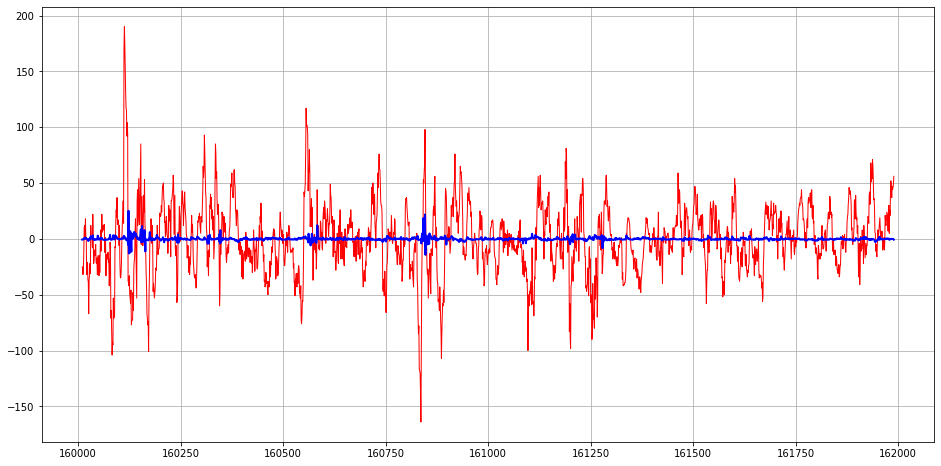

In [0]:
# i = 200
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(check_df['y'], color='r', linewidth = 1.0) # 正解
ax.plot(check_df['pred'], color='b', linewidth = 2.0) # 予測
ax.grid(True)
plt.show()

In [0]:
pd.set_option('display.max_rows', 100)

In [0]:
# 学習器を保存
dump(LGB, 'LGB_BB_s.cmp', compress=3)

['LGB_BB_s.cmp']

In [0]:
feature_importance = pd.DataFrame(data=LGB.feature_importance(), index=X.columns, columns=['f_imp'])

In [0]:
feature_importance.sort_values(by='f_imp', ascending=False)

,f_imp
Volume,138
Volume,88
Volume,80
Volume,76
Volume,73
...,...
Lシグナル,0
Sシグナル,0
Sシグナル,0
Sシグナル,0
